# Find TRI facilities near US Rivers

After outlining the story I wanted to tell about superfund sites and the TRI, I realized that water seemed to be an underlying theme in this mapping project. This notebook finds TRI facilities from 2018 located within one-mile of a river.

## Table of Contents

* [Load and wrangle data](#load-data)
* [Project data to equidistant projection](#project-data)
* [Define and run function](#function)
* [Re-project and export data](#export-data)

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import mapping
# import shapely.speedups
import matplotlib.pyplot as plt
# import timeit

# change default figsize
plt.rcParams['figure.figsize'] = (15, 12)

## Load and wrangle data <a name="load-data"></a>

In [2]:
# read state shapefiles into notebook
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

# main river shapefile
rivers = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_rivers_lake_centerlines.zip')

# north american supplementary river shapefile
supp = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_rivers_north_america.zip')

# read tri data in
tri = gpd.read_file('../data/map-data/tri-2018.geojson')

In [3]:
# check crs of river shapefiles
print(rivers.crs)
print(supp.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [4]:
# concatenate the two river shapefiles
all_rivers = gpd.GeoDataFrame(pd.concat([rivers, supp], ignore_index=True))

# define crs for new concatenated shapefile
all_rivers.crs = {'init' :'epsg:4326'}

all_rivers

,dissolve,scalerank,featurecla,name,name_alt,rivernum,note,min_zoom,name_en,min_label,...,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry,name_full,strokeweig,uident
0,0River,1.0,River,Irrawaddy Delta,None,0,None,2.0,Irrawaddy,3.0,...,Irrawaddy,İravadi Nehri,Sông Ayeyarwaddy,伊洛瓦底江,2,1159109417,"MULTILINESTRING ((95.45110 17.82050, 95.42766 ...",NaN,NaN,NaN
1,1001Lake Centerline,9.0,Lake Centerline,Tonle Sap,None,1001,None,7.1,None,8.1,...,None,None,None,None,4,1159109429,"MULTILINESTRING ((103.68743 13.22468, 103.7133...",NaN,NaN,NaN
2,1001River,9.0,River,Tonle Sap,None,1001,None,7.1,None,8.1,...,None,None,None,None,4,1159109445,"LINESTRING (104.61476 12.38203, 104.61769 12.3...",NaN,NaN,NaN
3,1002Lake Centerline,9.0,Lake Centerline,Sheksna,None,1002,None,7.1,Sheksna,8.1,...,Sjeksna,None,None,舍克斯納河,4,1159109447,"LINESTRING (37.73951 59.07954, 37.75733 59.103...",NaN,NaN,NaN
4,1002River,9.0,River,Sheksna,None,1002,None,7.1,Sheksna,8.1,...,Sjeksna,None,None,舍克斯納河,4,1159109461,"LINESTRING (38.47804 59.21666, 38.48528 59.228...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6710,23270Lake Centerline,11.0,Lake Centerline,None,None,23270,None,6.7,None,7.7,...,None,None,None,None,0,1159145985,"LINESTRING (-92.29186 48.24982, -92.29190 48.2...",None,0.2,0.0
6711,23271Lake Centerline,11.0,Lake Centerline,None,None,23271,None,6.7,None,7.7,...,None,None,None,None,0,1159145989,"LINESTRING (-92.46329 48.32962, -92.46349 48.3...",None,0.2,0.0
6712,23285Lake Centerline,11.0,Lake Centerline,Romaine,None,23285,None,6.7,Romaine,7.7,...,Rivière Romaine,None,None,None,4,1159145995,"LINESTRING (-63.83446 52.09345, -63.83202 52.1...",Rivire Romaine,0.2,0.0
6713,23291Lake Centerline,11.0,Lake Centerline,None,None,23291,None,6.7,None,7.7,...,None,None,None,None,0,1159145999,"LINESTRING (-68.40331 53.19355, -68.45311 53.2...",None,0.2,0.0


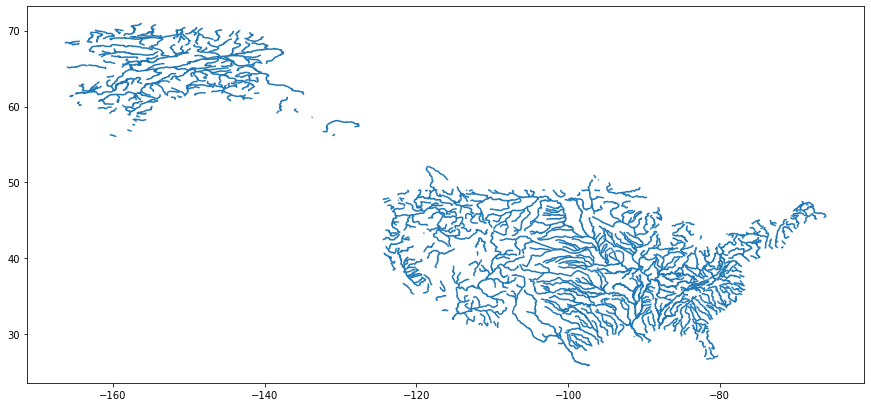

In [5]:
# create clipping mask from the states layer
states_poly = states.geometry.unary_union

# define us_rivers as those that intersect the states_poly clipping mask
us_rivers = all_rivers[all_rivers.geometry.intersects(states_poly)]

# plot results to check
us_rivers.plot();

## Project data to equidistant projection <a name="project-data"></a>

In [6]:
# check crs of each layer again
print(us_rivers.crs)
print(states.crs)
print(tri.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4269'}
{'init': 'epsg:4326'}


In [7]:
# project each layer to equidistant projection because I want to measure distance
states_eqdc = states.to_crs({'init': 'epsg:4087'})
tri_eqdc = tri.to_crs({'init': 'epsg:4087'})
us_rivers_eqdc = us_rivers.to_crs({'init': 'epsg:4087'})

#check crs of each re-projected layer
print(us_rivers_eqdc.crs)
print(states_eqdc.crs)
print(tri_eqdc.crs)

{'init': 'epsg:4087'}
{'init': 'epsg:4087'}
{'init': 'epsg:4087'}


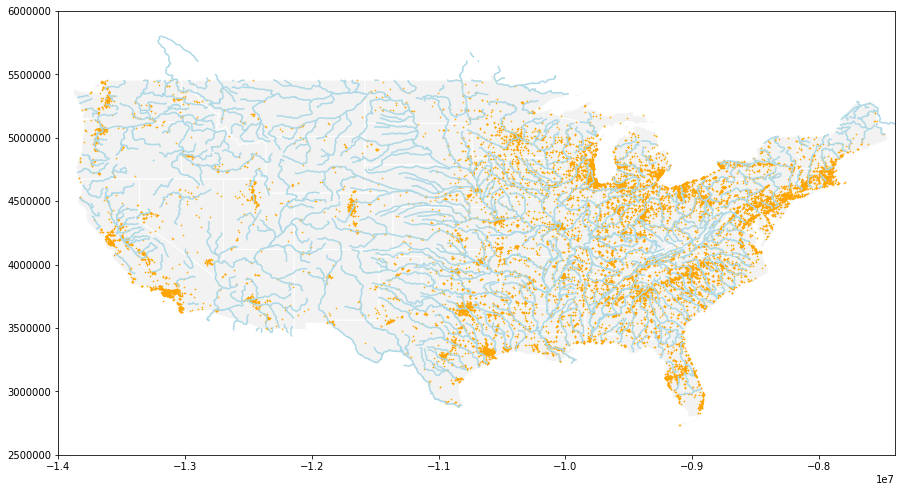

In [8]:
# plot re-projected data
fig, ax = plt.subplots()

states_eqdc.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
tri_eqdc.plot(ax=ax, color='orange', zorder=1, markersize=.4)
us_rivers_eqdc.plot(ax=ax, color='lightblue', zorder=2)
# us_lakes_eqdc.plot(ax=ax, color='#2EA1D3', zorder=3)

ax.set(xlim=(-14000000, -7400000), ylim=(2500000,6000000));

## Define and run function <a name="function"></a>

In [9]:
# define function that finds toxic sites located within 1609.34 meters of a river
# 1609.34 equals approximately 1 mile
def find_toxic_sites(site_frame, feature_frame):
    
    new_rows = []

    feature_frame_poly = feature_frame.geometry.unary_union
    
    for index, row in site_frame.iterrows():
        new_row = row
        if row['geometry'].distance(feature_frame_poly) < 1609.34:
            new_rows.append(new_row.values)

    located_sites = gpd.GeoDataFrame(new_rows, columns=site_frame.columns).reset_index()
    
    return located_sites

In [10]:
# run function
tri_near_rivers = find_toxic_sites(tri_eqdc, us_rivers_eqdc)

tri_near_rivers

,index,TRIFD,FACILITY_NAME,LATITUDE,LONGITUDE,INDUSTRY_SECTOR,PARENT_CO_NAME,geometry
0,0,01001HPHDN233MA,HP HOOD LLC - AGAWAM PLANT,42.084690,-72.618970,Food,HP HOOD LLC,POINT (-8083906.762 4684846.261)
1,1,01013HRCLS1111G,SOLENIS LLC,42.181944,-72.609167,Chemicals,,POINT (-8082815.497 4695672.527)
2,2,01013SPLDN425ME,CALLAWAY GOLF BALL OPERATIONS INC,42.175530,-72.614620,Miscellaneous Manufacturing,CALLAWAY GOLF CO,POINT (-8083422.523 4694958.524)
3,3,01013THMSP24MON,INTERNATIONAL METAL PRODUCTS CORP,42.188390,-72.599820,Fabricated Metals,,POINT (-8081774.994 4696390.092)
4,4,01020CHCPC158NE,CHICOPEE CONCRETE SERVICE,42.165558,-72.537224,Nonmetallic Mineral Product,CHICOPEE CONCRETE SERVICE INC,POINT (-8074806.839 4693848.446)
...,...,...,...,...,...,...,...,...
2552,2552,99363BSCSCPOBOX,BOISE WHITE PAPER LLC,46.103960,-118.918400,Paper,PACKAGING CORP OF AMERICA,POINT (-13237935.734 5132269.351)
2553,2553,9955WCRWLY38STA,CROWLEY MARINE SERVICES BETHEL,60.782580,-161.778750,Petroleum Bulk Terminals,CROWLEY FUELS LLC,POINT (-18009128.071 6766285.855)
2554,2554,99701GRTWS4199S,BRENNTAG PACIFIC INC,64.804287,-147.742338,Chemical Wholesalers,BRENNTAG N.A. INC,POINT (-16446601.835 7213980.230)
2555,2555,99705PTRST1200H,PETRO STAR INC NORTH POLE REFINERY,64.733253,-147.344964,Petroleum,ARCTIC SLOPE REGIONAL CORP,POINT (-16402366.363 7206072.761)


In [11]:
# set crs for tri near rivers
tri_near_rivers.crs = {'init': 'epsg:4087'}

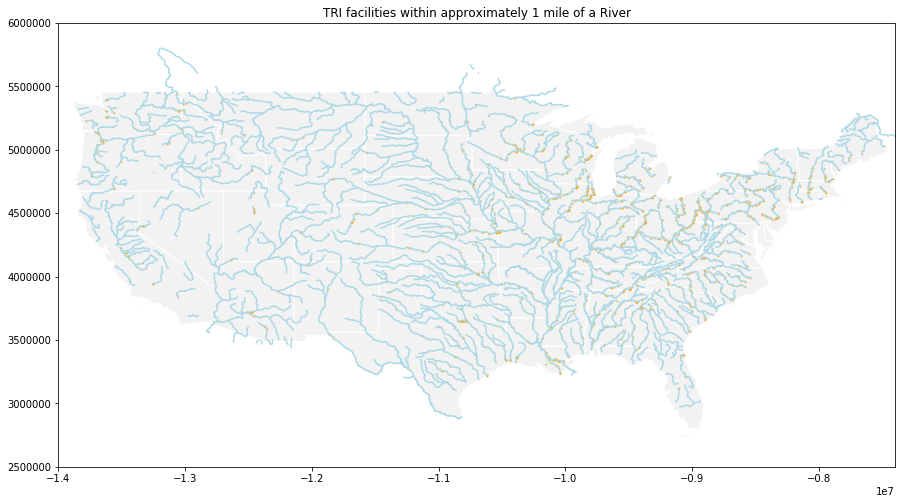

In [12]:
#plot data again using the data returned from my function
fig, ax = plt.subplots()

states_eqdc.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
tri_near_rivers.plot(ax=ax, color='orange', zorder=1, markersize=.4)
us_rivers_eqdc.plot(ax=ax, color='lightblue', zorder=2)

ax.set(xlim=(-14000000, -7400000), ylim=(2500000,6000000), title='TRI facilities within approximately 1 mile of a River');

## Re-project and export data <a name="export-data"></a>

In [13]:
# project rivers and tri near rivers to WGS84 for webmapping
tri_near_rivers = tri_near_rivers.to_crs({'init': 'epsg:4326'})
us_rivers = us_rivers.to_crs({'init': 'epsg:4326'})

In [14]:
# export geodataframe to geojson for further exploration
tri_near_rivers.to_file("../data/map-data/tri-near-rivers.geojson", driver='GeoJSON', encoding='utf-8')
us_rivers.to_file("../data/map-data/us-rivers.geojson", driver='GeoJSON', encoding='utf-8')